In [1]:
%load_ext autoreload
%autoreload 2 
%reload_ext autoreload
%matplotlib inline

import numpy as np
import scipy.io as io
from pyDOE import lhs
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

from complexPyTorch.complexLayers import ComplexLinear

import cplxmodule
from cplxmodule import cplx
from cplxmodule.nn import RealToCplx, CplxToReal, CplxSequential, CplxToCplx
from cplxmodule.nn import CplxLinear, CplxModReLU, CplxAdaptiveModReLU, CplxModulus, CplxAngle

# To access the contents of the parent dir
import sys; sys.path.insert(0, '../')
import os
from scipy.io import loadmat
from utils import *
from models import (TorchComplexMLP, ImaginaryDimensionAdder, 
                    cplx2tensor, ComplexTorchMLP, complex_mse, TanhProb)
from preprocess import *

# Model selection
# from sparsereg.model import STRidge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from pde_diff import TrainSTRidge, FiniteDiff, print_pde
from RegscorePy.bic import bic

from madgrad import MADGRAD

Running Python 3.9.6
You can use npar for np.array


In [2]:
# torch device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You're running on", device)

# Doman bounds
lb = np.array([-5.0, 0.0])
ub = np.array([5.0, np.pi/2])

DATA_PATH = '../experimental_data/NLS.mat'
data = io.loadmat(DATA_PATH)

t = data['tt'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = data['uu']
Exact_u = np.real(Exact)
Exact_v = np.imag(Exact)

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = to_column_vector(Exact_u.T)
v_star = to_column_vector(Exact_v.T)

N = 500; include_N_res = 1
idx = np.random.choice(X_star.shape[0], N, replace=False)
# idx = np.arange(N) # Just have an easy dataset for experimenting

lb = to_tensor(lb, False).to(device)
ub = to_tensor(ub, False).to(device)

X_train = to_tensor(X_star[idx, :], True).to(device)
u_train = to_tensor(u_star[idx, :], False).to(device)
v_train = to_tensor(v_star[idx, :], False).to(device)

# Unsup data
if include_N_res>0:
    N_res = int(N*include_N_res)
    idx_res = np.array(range(X_star.shape[0]-1))[~idx]
    idx_res = idx_res[:N_res]
    X_res = to_tensor(X_star[idx_res, :], True)
    print(f"Training with {N_res} unsup samples")
    X_train = torch.vstack([X_train, X_res])

feature_names = ['hf', '|hf|', 'h_x', 'h_xx', 'h_xxx']

### Loading data code here ###
print("Loading pre-calculated data for reproducibility")
X_train = to_tensor(np.load("./tmp_files/X_train_500+500samples.npy"), True)
u_train, v_train = dimension_slicing(to_tensor(np.load("./tmp_files/uv_train_500samples.npy"), False))
### ----- ###

You're running on cpu
Training with 500 unsup samples
Loading pre-calculated data for reproducibility


In [3]:
spatial_dim = x.shape[0]
time_dim = t.shape[0]

dt = (t[1]-t[0])[0]
dx = (x[2]-x[1])[0]

fd_h_t = np.zeros((spatial_dim, time_dim), dtype=np.complex64)
fd_h_x = np.zeros((spatial_dim, time_dim), dtype=np.complex64)
fd_h_xx = np.zeros((spatial_dim, time_dim), dtype=np.complex64)
fd_h_xxx = np.zeros((spatial_dim, time_dim), dtype=np.complex64)

for i in range(spatial_dim):
    fd_h_t[i,:] = FiniteDiff(Exact[i,:], dt, 1)
for i in range(time_dim):
    fd_h_x[:,i] = FiniteDiff(Exact[:,i], dx, 1)
    fd_h_xx[:,i] = FiniteDiff(Exact[:,i], dx, 2)
    fd_h_xxx[:,i] = FiniteDiff(Exact[:,i], dx, 3)
    
fd_h_t = np.reshape(fd_h_t, (spatial_dim*time_dim,1), order='F')
fd_h_x = np.reshape(fd_h_x, (spatial_dim*time_dim,1), order='F')
fd_h_xx = np.reshape(fd_h_xx, (spatial_dim*time_dim,1), order='F')
fd_h_xxx = np.reshape(fd_h_xxx, (spatial_dim*time_dim,1), order='F')

In [4]:
inp_dimension = 2
act = CplxToCplx[torch.tanh]
complex_model = CplxSequential(
                            CplxLinear(100, 100, bias=True),
                            act(),
                            CplxLinear(100, 100, bias=True),
                            act(),
                            CplxLinear(100, 100, bias=True),
                            act(),
                            CplxLinear(100, 100, bias=True),
                            act(),
                            CplxLinear(100, 1, bias=True),
                            )

complex_model = torch.nn.Sequential(
                                    torch.nn.Linear(inp_dimension, 200),
                                    RealToCplx(),
                                    complex_model
                                    )

# complex_model.load_state_dict(cpu_load("./saved_path_inverse_nls/NLS_cpinn_model.pth"))
complex_model.load_state_dict(cpu_load("./saved_path_inverse_nls/NLS_complex_model_500labeledsamples.pth"))

/usr/local/lib/python3.9/site-packages/torch/nn/modules/container.py:597: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


<All keys matched successfully>

### some tests

In [5]:
xx, tt = dimension_slicing(to_tensor(X_train[:N, :], True))
predictions = complex_model(cat(xx, tt))
h = cplx2tensor(predictions)
h_x = complex_diff(predictions, xx)
h_xx = complex_diff(h_x, xx)
h_xxx = complex_diff(h_xx, xx)
h_t = complex_diff(predictions, tt)

/Users/pongpisit/Desktop/Multi-task-Physics-informed-neural-networks/inverse_NLS/../utils.py:188: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(arr).float().requires_grad_(g)


In [6]:
f = 1j*h_t+0.5*h_xx+(h.abs()**2)*h

In [7]:
# PDE Loss 1.1325556442898232e-05
# MSE Loss 4.512887699092971e-06
real_loss = (f.real**2).mean(); imag_loss = (f.imag**2).mean()
avg_loss = (real_loss+imag_loss)*0.5
print("PDE Loss", avg_loss.item())
print("MSE Loss", complex_mse(predictions, u_train+1j*v_train).item())

PDE Loss 0.00830211490392685
MSE Loss 3.642554656835273e-05


In [8]:
derivatives = to_numpy(cat(h, h.abs()**2, h_x, h_xx, h_xxx))
dictionary = {}
for i in range(len(feature_names)): dictionary[feature_names[i]] = get_feature(derivatives, i)
# dictionary

In [9]:
c_poly = ComplexPolynomialFeatures(feature_names, dictionary)
complex_poly_features = c_poly.fit()
complex_poly_features

Computing hf
Computing |hf|
Computing h_x
Computing h_xx
Computing h_xxx
Computing hf^2
Computing hf |hf|
Computing hf h_x
Computing hf h_xx
Computing hf h_xxx
Computing |hf|^2
Computing |hf| h_x
Computing |hf| h_xx
Computing |hf| h_xxx
Computing h_x^2
Computing h_x h_xx
Computing h_x h_xxx
Computing h_xx^2
Computing h_xx h_xxx
Computing h_xxx^2


array([[ 1.0000000e+00+0.0000000e+00j,  1.8287402e-01+9.5849973e-01j,
         9.5216465e-01+0.0000000e+00j, ...,
         1.7851934e+01-4.6664425e+01j,  3.1865616e+01-9.3093842e+01j,
         5.6193420e+01-1.8545619e+02j],
       [ 1.0000000e+00+0.0000000e+00j,  6.7636567e-01+1.4373595e-01j,
         4.7813055e-01+0.0000000e+00j, ...,
        -2.3702056e+00+5.3106542e+00j,  6.6533599e+00-1.3724621e+01j,
        -1.8578472e+01+3.5425545e+01j],
       [ 1.0000000e+00+0.0000000e+00j,  6.0341483e-01+2.3708993e-01j,
         4.2032108e-01+0.0000000e+00j, ...,
        -4.2094916e-01+4.9473611e-01j, -8.7446731e-01+1.8341792e+00j,
        -1.1678257e+00+6.2480083e+00j],
       ...,
       [ 1.0000000e+00+0.0000000e+00j,  3.6971271e-02+5.2270472e-02j,
         4.0990775e-03+0.0000000e+00j, ...,
         3.8725277e-04+4.5041209e-03j, -4.1001476e-07+3.6970994e-03j,
        -2.5966717e-04+3.0123498e-03j],
       [ 1.0000000e+00+0.0000000e+00j,  1.5098518e-01+1.0398209e-01j,
         3.3608802e-02

In [10]:
w = TrainSTRidge(complex_poly_features, to_numpy(h_t), 1e-10, d_tol=1000, maxit=1000)
print("PDE derived using STRidge")
print_pde(w, c_poly.poly_feature_names)

PDE derived using STRidge
u_t = (-0.008224 +0.498694i)h_xx
    + (-0.006229 +0.997566i)hf |hf|
   


#### Automatic differentiation w/ and w/o Finite difference guidance

In [11]:
class ComplexNetwork(nn.Module):
    def __init__(self, model, index2features=None, scale=False, lb=None, ub=None):
        super(ComplexNetwork, self).__init__()
        # pls init the self.model before
        self.model = model
        # For tracking, the default tup is for the burgers' equation.
        self.index2features = index2features
        print("Considering", self.index2features)
        self.diff_flag = diff_flag(self.index2features)
        self.uf = None
        self.scale = scale
        self.lb, self.ub = lb, ub
        
    def xavier_init(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    def forward(self, x, t):
        if not self.scale: self.uf = self.model(torch.cat([x, t], dim=1))
        else: self.uf = self.model(self.neural_net_scale(torch.cat([x, t], dim=1)))
        return self.uf
    
    def get_selector_data(self, x, t):
        uf = self.forward(x, t)
        u_t = complex_diff(uf, t)
        
        ### PDE Loss calculation ###
        # Without calling grad
        derivatives = []
        for t in self.diff_flag[0]:
            if t=='hf': 
                derivatives.append(cplx2tensor(uf))
                derivatives.append((uf.real**2+uf.imag**2)+0.0j)
            elif t=='x': derivatives.append(x)
        # With calling grad
        for t in self.diff_flag[1]:
            out = uf
            for c in t:
                if c=='x': out = complex_diff(out, x)
                elif c=='t': out = complex_diff(out, t)
            derivatives.append(out)
        
        return torch.cat(derivatives, dim=-1), u_t
    
    def neural_net_scale(self, inp):
        return 2*(inp-self.lb)/(self.ub-self.lb)-1

In [12]:
class ComplexAttentionSelectorNetwork(nn.Module):
    def __init__(self, layers, prob_activation=torch.sigmoid, bn=None, reg_intensity=5e-2):
        super(ComplexAttentionSelectorNetwork, self).__init__()
        # Nonlinear model, Training with PDE reg.
        assert len(layers) > 1
        self.linear1 = CplxLinear(layers[0], layers[0], bias=True)
        self.prob_activation = prob_activation
        self.nonlinear_model = ComplexTorchMLP(dimensions=layers, activation_function=CplxToCplx[F.relu](), bn=bn, dropout_rate=0.0)
        self.latest_weighted_features = None
#         self.th = 0.1
        self.th = (1/layers[0])+(1e-10)
        self.reg_intensity = reg_intensity
        self.w = torch.tensor([1.0, 1.0, 2.0, 2.0, 3.0])/10
        
    def xavier_init(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        
    def forward(self, inn):
        return self.nonlinear_model(inn*F.threshold(self.weighted_features(inn), self.th, 0.0))
    
    def weighted_features(self, inn):
#         self.latest_weighted_features = cplx2tensor(self.linear1(inn)).abs().mean(dim=0)
        self.latest_weighted_features = self.prob_activation(self.linear1(inn).real).mean(dim=0)
        return self.latest_weighted_features
    
    def loss(self, X_input, y_input):
        ut_approx = self.forward(X_input)
        l1 = complex_mse(ut_approx, y_input)
        reg_term = F.relu(self.latest_weighted_features-self.th)
        l2 = torch.norm(reg_term, p=0)+torch.dot(self.w, reg_term)
        return l1 + self.reg_intensity*l2

# Only the SemiSupModel has changed to work with the finite difference guidance
class SemiSupModel(nn.Module):
    def __init__(self, network, selector, normalize_derivative_features=False, mini=None, maxi=None, uncert=False):
        super(SemiSupModel, self).__init__()
        self.network = network
        self.selector = selector
        self.normalize_derivative_features = normalize_derivative_features
        self.mini = mini
        self.maxi = maxi
        self.weights = None
        if uncert: 
            self.weights = torch.tensor([0.0, 0.0])
        
    def forward(self, X_h_train, h_train, include_unsup=True):
        X_selector, y_selector = self.network.get_selector_data(*dimension_slicing(X_h_train))
        
        h_row = h_train.shape[0]
        fd_guidance = complex_mse(self.network.uf[:h_row, :], h_train)
        
        # I am not sure a good way to normalize/scale a complex tensor
        if self.normalize_derivative_features:
            X_selector = (X_selector-self.mini)/(self.maxi-self.mini)
        
        if include_unsup: unsup_loss = self.selector.loss(X_selector, y_selector)
        else: unsup_loss = None
            
        if include_unsup and self.weights is not None:
            return (torch.exp(-self.weights[0])*fd_guidance)+self.weights[0], (torch.exp(-self.weights[1])*unsup_loss)+self.weights[1]
        else:
            return fd_guidance, unsup_loss

In [13]:
h_star = (u_star+1j*v_star)

fd_derivatives = np.hstack([h_star, h_star.real**2+h_star.imag**2, fd_h_x, fd_h_xx, fd_h_xxx])

semisup_model = SemiSupModel(
    network=ComplexNetwork(model=complex_model, index2features=feature_names, scale=False, lb=lb, ub=ub),
    selector=ComplexAttentionSelectorNetwork([len(feature_names), 50, 50, 1], prob_activation=TanhProb(), bn=True),
    normalize_derivative_features=False,
    mini=torch.tensor(np.abs(fd_derivatives).min(axis=0), dtype=torch.cfloat),
    maxi=torch.tensor(np.abs(fd_derivatives).max(axis=0), dtype=torch.cfloat),
    uncert=True,
)

del h_star, fd_derivatives, fd_h_x, fd_h_xx, fd_h_xxx

Considering ['hf', '|hf|', 'h_x', 'h_xx', 'h_xxx']


/usr/local/lib/python3.9/site-packages/torch/nn/modules/container.py:597: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


In [14]:
IS_UNCERT = True
def pcgrad_closure(return_list=False):
    global IS_UNCERT, N, X_train, u_train, v_train, fd_derivatives, fd_u_t
    fd_guidance, unsup_loss = semisup_model(X_train, u_train+1j*v_train, include_unsup=True)      
    losses = [fd_guidance, unsup_loss]
    updated_grads = []
    
    for i in range(2):
        optimizer.zero_grad()
        losses[i].backward(retain_graph=True)

        g_task = []
        for param in semisup_model.parameters():
            if param.grad is not None:
                g_task.append(Variable(param.grad.clone(), requires_grad=False))
            else:
                g_task.append(Variable(torch.zeros(param.shape), requires_grad=False))
        # appending the gradients from each task
        updated_grads.append(g_task)

    updated_grads = list(pcgrad.pc_grad_update(updated_grads))[0]
    for idx, param in enumerate(semisup_model.parameters()):
        param.grad = (updated_grads[0][idx]+updated_grads[1][idx])
        
    if not return_list: return sum(losses)
    else: return losses

#### Joint training

In [15]:
# # Joint training
# optimizer = MADGRAD([{'params':semisup_model.network.parameters()}, {'params':semisup_model.selector.parameters()}], lr=1e-6)
# optimizer.param_groups[0]['lr'] = 1e-7
# optimizer.param_groups[1]['lr'] = 1e-1

# best_loss = 1000; best_state = None
# for i in range(100):
#     semisup_model.train()
#     optimizer.step(pcgrad_closure)
    
#     if i%10==0: 
#         loss = pcgrad_closure(return_list=True); print(loss)
#         fi = semisup_model.selector.latest_weighted_features
#         print(fi); print(torch.argsort(fi))

In [16]:
xx, tt = dimension_slicing(to_tensor(X_train, True))
predictions = semisup_model.network(xx, tt)
h = cplx2tensor(predictions)
h_x = complex_diff(predictions, xx)
h_xx = complex_diff(h_x, xx)
h_xxx = complex_diff(h_xx, xx)
h_t = complex_diff(predictions, tt)

/Users/pongpisit/Desktop/Multi-task-Physics-informed-neural-networks/inverse_NLS/../utils.py:188: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(arr).float().requires_grad_(g)


In [17]:
f = 1j*h_t+0.5*h_xx+(h.abs()**2)*h
real_loss = (f.real**2).mean(); imag_loss = (f.imag**2).mean()
avg_loss = (real_loss+imag_loss)*0.5
print("PDE Loss", avg_loss.item())
print("MSE Loss", complex_mse(predictions[:N, :], torch.tensor(u_train+1j*v_train, dtype=torch.cfloat)).item())

PDE Loss 0.007333296816796064
MSE Loss 3.642554656835273e-05


<ipython-input-17-f31165840332>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print("MSE Loss", complex_mse(predictions[:N, :], torch.tensor(u_train+1j*v_train, dtype=torch.cfloat)).item())


In [18]:
# save(semisup_model, "tmp.pth")

In [19]:
print("Loading weights")
semisup_model.load_state_dict(torch.load("tmp.pth"))

Loading weights


<All keys matched successfully>

#### Fine-tuning both the solver and selector network

In [20]:
# Fine-tuning the solver network
f_opt = torch.optim.LBFGS(semisup_model.network.parameters(), lr=1e-1, max_iter=500, history_size=500)

def finetuning_closure():
    global IS_UNCERT, N, X_train, u_train, v_train, fd_derivatives, fd_u_t
    if torch.is_grad_enabled(): f_opt.zero_grad()
    # the solver network only consider the first N samples.
    loss = complex_mse(semisup_model.network(*dimension_slicing(X_train[:N, :])), u_train+1j*v_train)
    if loss.requires_grad: loss.backward(retain_graph=True)
    return loss

semisup_model.network.train()
semisup_model.selector.eval()

for i in range(200):
    f_opt.step(finetuning_closure)
    
    if i%10==0:
        loss = finetuning_closure()
        print(loss.item())

1.1693950909830164e-06
1.167013579106424e-06
1.1668932984321145e-06
1.1668932984321145e-06
1.1668932984321145e-06
1.1668932984321145e-06
1.1668932984321145e-06
1.1668932984321145e-06
1.1668932984321145e-06
1.1668932984321145e-06
1.1668932984321145e-06
1.1668932984321145e-06
1.1668932984321145e-06
1.1668932984321145e-06
1.1668932984321145e-06
1.1668932984321145e-06
1.1668932984321145e-06
1.1668932984321145e-06
1.1668932984321145e-06
1.1668932984321145e-06


In [21]:
xx, tt = dimension_slicing(to_tensor(X_train, True))
predictions = semisup_model.network(xx, tt)
h = cplx2tensor(predictions)
h_x = complex_diff(predictions, xx)
h_xx = complex_diff(h_x, xx)
h_xxx = complex_diff(h_xx, xx)
h_t = complex_diff(predictions, tt)

f = 1j*h_t+0.5*h_xx+(h.abs()**2)*h
real_loss = (f.real**2).mean(); imag_loss = (f.imag**2).mean()
avg_loss = (real_loss+imag_loss)*0.5
print("PDE Loss", avg_loss.item())
print("MSE Loss", complex_mse(predictions[:N, :], torch.tensor(u_train+1j*v_train, dtype=torch.cfloat)).item())

derivatives = to_numpy(cat(h, h.abs()**2, h_x, h_xx, h_xxx))
dictionary = {}
for i in range(len(feature_names)): dictionary[feature_names[i]] = get_feature(derivatives, i)

c_poly = ComplexPolynomialFeatures(feature_names, dictionary)
complex_poly_features = c_poly.fit()

w = TrainSTRidge(complex_poly_features, to_numpy(h_t), 1e-10, d_tol=1000, maxit=1000)
print("PDE derived using STRidge")
print_pde(w, c_poly.poly_feature_names)

PDE Loss 0.006740952841937542
MSE Loss 1.1668932984321145e-06
Computing hf
Computing |hf|
Computing h_x
Computing h_xx
Computing h_xxx
Computing hf^2
Computing hf |hf|
Computing hf h_x
Computing hf h_xx
Computing hf h_xxx
Computing |hf|^2
Computing |hf| h_x
Computing |hf| h_xx
Computing |hf| h_xxx
Computing h_x^2
Computing h_x h_xx
Computing h_x h_xxx
Computing h_xx^2
Computing h_xx h_xxx
Computing h_xxx^2


<ipython-input-21-3e99f5f7ba17>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print("MSE Loss", complex_mse(predictions[:N, :], torch.tensor(u_train+1j*v_train, dtype=torch.cfloat)).item())


PDE derived using STRidge
u_t = (0.003456 +0.501238i)h_xx
    + (0.002515 +1.003159i)hf |hf|
   


In [22]:
X_selector, y_selector = semisup_model.network.get_selector_data(*dimension_slicing(X_train))

In [23]:
# Due to the different loss calculaition in ComplexAttentionSelectorNetwork's forward pass
# Reinit the selector network weights in a bad way
# Reinit != slow convergence if the # of data samples are small

# semisup_model.selector.nonlinear_model = ComplexTorchMLP(dimensions=[len(feature_names), 50, 50, 1], activation_function=CplxToCplx[F.relu](), bn=True, dropout_rate=0.0)
# semisup_model.selector.th = 1/len(feature_names)+(1e-10)
semisup_model.selector.reg_intensity = 1e-3 # V2

In [24]:
# Fine-tuning the selector network
f_opt = torch.optim.LBFGS(semisup_model.selector.parameters(), lr=5e-2, max_iter=300, history_size=300)

def finetuning_closure():
    if torch.is_grad_enabled(): f_opt.zero_grad()
    # Am I forget to normalize the derivative features?, NVM
    loss = semisup_model.selector.loss(X_selector, y_selector) # V2
#     loss = complex_mse(semisup_model.selector(X_selector), y_selector) # V1
    if loss.requires_grad: loss.backward(retain_graph=True)
    return loss

semisup_model.network.eval()
semisup_model.selector.train()

for i in range(1):
    f_opt.step(finetuning_closure)
    
    if i%5==0:
        with torch.no_grad():
            loss = finetuning_closure()
            print(loss.item())
            
            fi = semisup_model.selector.latest_weighted_features.detach().numpy()
            print(fi)
            print(np.argsort(fi))

            # Changing the optimizer
            if i==20: f_opt = MADGRAD(semisup_model.selector.parameters(), lr=1e-6)

0.0037240830715745687
[0.9329563  0.54446095 0.16231604 0.2599501  0.08875209]
[4 2 3 1 0]


In [25]:
# save(semisup_model, "semisup_modelV2.pth")

In [26]:
feature_importance = semisup_model.selector.latest_weighted_features.detach().numpy()
print("--- Feature importance ranking ---")
for idx in np.argsort(feature_importance)[::-1]:
    print(feature_names[idx], feature_importance[idx])

--- Feature importance ranking ---
hf 0.9329563
|hf| 0.54446095
h_xx 0.2599501
h_x 0.16231604
h_xxx 0.08875209


In [27]:
import matplotlib.pyplot as plt

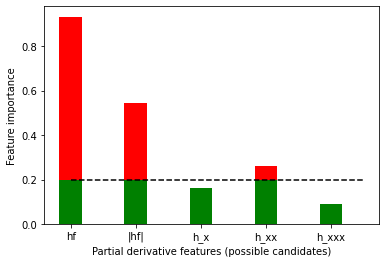

In [31]:
def plot_feature_importance_neural_net(feature_importances, feature_names, threshold=0.2, save_path=None):
    # split it up
    above_threshold = np.maximum(feature_importance - threshold, 0)
    below_threshold = np.minimum(feature_importance, threshold)

    # and plot it
    fig, ax = plt.subplots()
    ax.bar(feature_names, below_threshold, 0.35, color="g")
    ax.bar(feature_names, above_threshold, 0.35, color="r",
            bottom=below_threshold)
    # horizontal line indicating the threshold
    ax.plot([0., 4.5], [threshold, threshold], "k--")
    plt.xlabel("Partial derivative features (possible candidates)")
    plt.ylabel("Feature importance")
    
    if save_path is not None: fig.savefig(save_path, dpi=200)

plot_feature_importance_neural_net(feature_importance, feature_names,threshold=1/len(feature_names), save_path=None)